# Project 1: Customer Churn Estimation using Fuzzy Inference Systems (FIS)

### 1. Introduction: Why Fuzzy Logic?
In traditional binary logic, a customer is either "Loyal" ($0$) or "Churn" ($1$). However, human behavior is not binary. A customer might be "somewhat unsatisfied" or "moderately loyal."

**Fuzzy Logic** allows us to represent these linguistic uncertainties using **Membership Functions**. Instead of a sharp transition, we define a degree of membership between $0$ and $1$.

### 2. Mathematical Foundation
Let $X$ be the universe of discourse (e.g., Monthly Charges). A fuzzy set $A$ in $X$ is defined as:
$$A = \{ (x, \mu_A(x)) \mid x \in X \}$$

Where $\mu_A(x)$ is the **Membership Function (MF)**. For our Churn problem, we will define membership functions for:
* **Tenure (Usage Duration):** Short, Medium, Long
* **Monthly Charges:** Low, Medium, High
* **Churn Probability (Output):** Low, Medium, High

### 3. The Architecture (Mamdani Inference)
The process follows three main steps:
1.  **Fuzzification:** Converting crisp input values (e.g., $\$70$ bill) into fuzzy membership degrees.
2.  **Rule Evaluation:** Applying "IF-THEN" logic.
    * *Example:* IF Tenure is **Short** AND Monthly Charges are **High**, THEN Churn Probability is **High**.
3.  **Defuzzification:** Converting the fuzzy output back into a single crisp number (Probability Score) using the **Centroid Method**:
$$z^* = \frac{\int \mu_C(z) \cdot z \, dz}{\int \mu_C(z) \, dz}$$

---

In [2]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Tanımlamalar: Giriş ve Çıkış Değişkenleri (Antecedents & Consequent)
# Tenure (0-72 ay), MonthlyCharges (0-150 $), Churn (0-100 score)
tenure = ctrl.Antecedent(np.arange(0, 73, 1), 'tenure')
monthly_charges = ctrl.Antecedent(np.arange(0, 151, 1), 'monthly_charges')
churn_prob = ctrl.Consequent(np.arange(0, 101, 1), 'churn_prob')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.8 MB/s eta 0:00:00


### 4. Membership Function (MF) Design
To translate "crisp" numbers into "fuzzy" concepts, we need to define the shape of our sets. We will use **Triangular Membership Functions (trimf)** for simplicity and clear interpretability.

* **Tenure (Months):**
    * *Short:* 0 - 12 months (New and high risk)
    * *Medium:* 10 - 48 months (Transition phase)
    * *Long:* 40+ months (Established loyalty)
* **Monthly Charges ($):**
    * *Low:* 0 - 40
    * *Medium:* 30 - 90
    * *High:* 70 - 150
* **Churn Probability (%):**
    * *Low:* 0 - 30%
    * *Medium:* 25 - 75%
    * *High:* 70 - 100%

**Mathematical Note:** Notice the overlaps. For example, a monthly charge of $35 belongs to both "Low" and "Medium" sets with different degrees. This overlap is what captures the "uncertainty."

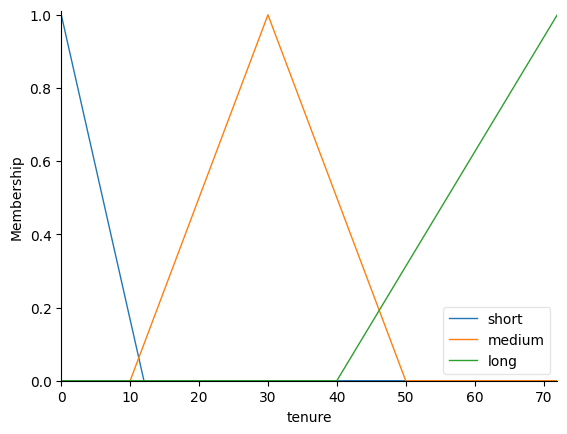

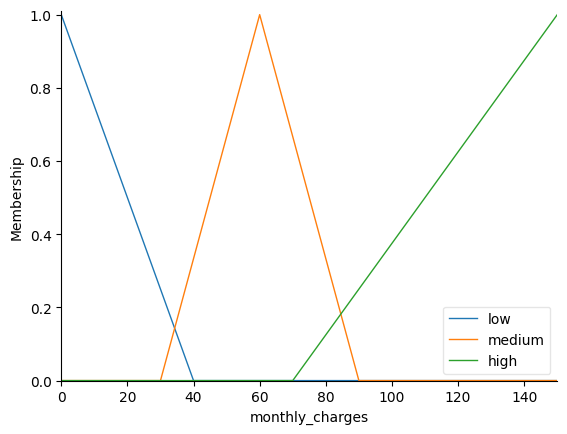

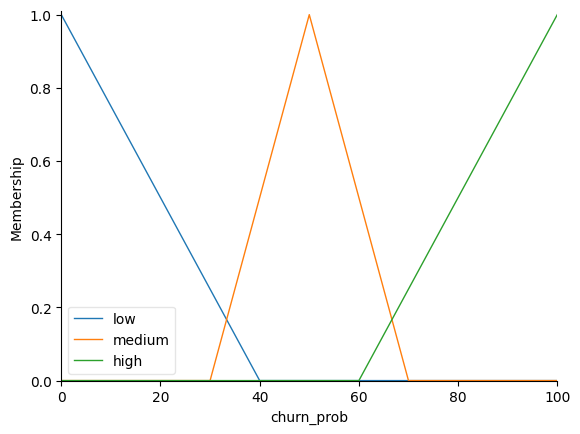

In [3]:
# 2. Üyelik Fonksiyonlarını Tanımlama (Otomatik veya Manuel)

# Tenure için otomatik 3 kategori (poor, average, good yerine isimlendirelim)
tenure['short'] = fuzz.trimf(tenure.universe, [0, 0, 12])
tenure['medium'] = fuzz.trimf(tenure.universe, [10, 30, 50])
tenure['long'] = fuzz.trimf(tenure.universe, [40, 72, 72])

# Monthly Charges
monthly_charges['low'] = fuzz.trimf(monthly_charges.universe, [0, 0, 40])
monthly_charges['medium'] = fuzz.trimf(monthly_charges.universe, [30, 60, 90])
monthly_charges['high'] = fuzz.trimf(monthly_charges.universe, [70, 150, 150])

# Churn Probability (Output)
churn_prob['low'] = fuzz.trimf(churn_prob.universe, [0, 0, 40])
churn_prob['medium'] = fuzz.trimf(churn_prob.universe, [30, 50, 70])
churn_prob['high'] = fuzz.trimf(churn_prob.universe, [60, 100, 100])

# Görselleştirme
tenure.view()
monthly_charges.view()
churn_prob.view()

### 5. The Rule Base: Modeling Business Logic
The "brain" of our Fuzzy System consists of **IF-THEN** rules. These rules are not just random; they reflect the tension between **Price Sensitivity** and **Brand Loyalty**.

We define 3 main strategies in our rules:
1.  **The Danger Zone:** High monthly charges combined with short tenure leads to an almost certain churn.
2.  **The Loyalty Buffer:** Long-term customers are less likely to leave even with medium-to-high prices, but they have a limit.
3.  **The Safe Haven:** Low prices and long tenure represent the most stable customer base.

**Linguistic Rules:**
* **Rule 1:** IF *Tenure* is **Short** AND *Monthly Charges* are **High**, THEN *Churn* is **High**. (Aggressive Churn)
* **Rule 2:** IF *Tenure* is **Long** OR *Monthly Charges* are **Low**, THEN *Churn* is **Low**. (Loyalty wins)
* **Rule 3:** IF *Tenure* is **Medium** AND *Monthly Charges* are **Medium**, THEN *Churn* is **Medium**. (Neutral state)
* **Rule 4:** IF *Tenure* is **Short** AND *Monthly Charges* are **Low**, THEN *Churn* is **Medium**. (New customers are volatile even if it's cheap)

In [4]:
# 3. Kural Setinin Oluşturulması
# Burada 've' (AND) için '&', 'veya' (OR) için '|' operatörlerini kullanıyoruz.

rule1 = ctrl.Rule(tenure['short'] & monthly_charges['high'], churn_prob['high'])
rule2 = ctrl.Rule(tenure['long'] | monthly_charges['low'], churn_prob['low'])
rule3 = ctrl.Rule(tenure['medium'] & monthly_charges['medium'], churn_prob['medium'])
rule4 = ctrl.Rule(tenure['short'] & monthly_charges['low'], churn_prob['medium'])
rule5 = ctrl.Rule(tenure['long'] & monthly_charges['high'], churn_prob['medium']) # Sadakat fiyatı dengeler

# 4. Kontrol Sistemini Kurma (Inference System)
churn_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
churn_sim = ctrl.ControlSystemSimulation(churn_ctrl)

print("Inference Engine successfully built. Ready for simulation.")

Inference Engine successfully built. Ready for simulation.


### 6. Simulation: Testing a Specific Scenario
Let's put our model to the test with a high-risk customer profile:
* **Tenure:** 6 months (New customer)
* **Monthly Charges:** $110 (Premium payer)

We use the **Centroid Method** to find the "center of gravity" of the resulting fuzzy set. This gives us a single probability score.

### 7. The Decision Surface (The "Why" of our Model)
To truly understand our model, we will plot a **3D Surface**. This map shows how *Churn Probability* changes as *Tenure* and *Monthly Charges* vary simultaneously.
* This is the ultimate "Executive Summary" for stakeholders.
* It reveals "non-linear" behaviors that a simple linear regression would miss.

Calculated Churn Probability: 84.44%


KeyError: 'churn_prob'

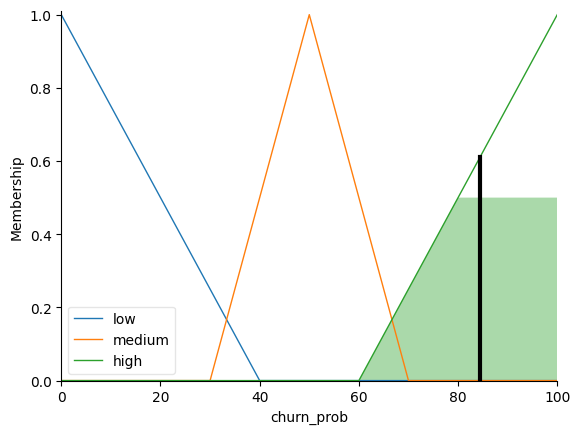

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D grafik için

# 5. Örnek Senaryo: Yeni ve Pahalı Paket Kullanan Müşteri
churn_sim.input['tenure'] = 6
churn_sim.input['monthly_charges'] = 110

# Hesaplama (Crunching the numbers)
churn_sim.compute()
print(f"Calculated Churn Probability: {churn_sim.output['churn_prob']:.2f}%")
churn_prob.view(sim=churn_sim)

# 6. 3D Karar Yüzeyi (The Masterpiece)
upsampled_tenure = np.linspace(0, 72, 20)
upsampled_charges = np.linspace(0, 150, 20)
x, y = np.meshgrid(upsampled_tenure, upsampled_charges)
z = np.zeros_like(x)

for i in range(20):
    for j in range(20):
        churn_sim.input['tenure'] = x[i, j]
        churn_sim.input['monthly_charges'] = y[i, j]
        churn_sim.compute()
        z[i, j] = churn_sim.output['churn_prob']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')

ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Monthly Charges ($)')
ax.set_zlabel('Churn Probability (%)')
ax.set_title('Fuzzy Logic Decision Surface')
plt.show()

### 8. The Completeness Problem
A fuzzy system is **complete** if and only if for every possible input vector $(x_1, x_2, ..., x_n)$, there is at least one rule that fires with a non-zero membership degree:
$$\sum_{i=1}^{n} \mu_{Rule_i}(x) > 0$$

If this condition fails, the system returns a `KeyError` because the output set is empty. In our case, some combinations of *Tenure* and *Monthly Charges* were falling into "mathematical gaps" between our rules.

**The Solution:**
1.  **Rule Expansion:** Add a "catch-all" or more granular rules to cover the gaps.
2.  **Exception Handling:** In the simulation loop, we will use a `try-except` block to handle cases where the logic doesn't trigger, ensuring our 3D plot doesn't crash.

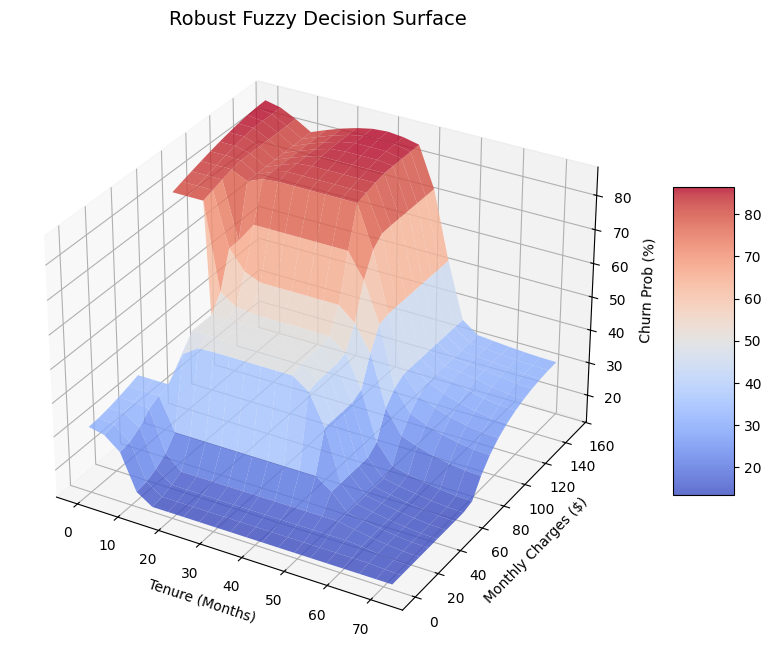

In [6]:
# 1. Kural setini genişletelim (Eksik kalan kombinasyonları yamayalım)
rule6 = ctrl.Rule(tenure['medium'] & monthly_charges['low'], churn_prob['low'])
rule7 = ctrl.Rule(tenure['medium'] & monthly_charges['high'], churn_prob['high'])

# Sistemi yeni kurallarla güncelleyelim
churn_ctrl_v2 = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
churn_sim_v2 = ctrl.ControlSystemSimulation(churn_ctrl_v2)

# 2. 3D Yüzey Çizimi (Hata Kontrollü)
z = np.zeros_like(x)

for i in range(20):
    for j in range(20):
        churn_sim_v2.input['tenure'] = x[i, j]
        churn_sim_v2.input['monthly_charges'] = y[i, j]
        try:
            churn_sim_v2.compute()
            z[i, j] = churn_sim_v2.output['churn_prob']
        except:
            # Eğer kural tetiklenmezse, o noktayı 0 veya bir önceki değer kabul et
            z[i, j] = np.nan

# Görselleştirme
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# 'nan' değerleri temizleyerek çiziyoruz
mask = np.isfinite(z)
surf = ax.plot_surface(x, y, z, cmap='coolwarm', edgecolor='none', alpha=0.8)

ax.set_title('Robust Fuzzy Decision Surface', fontsize=14)
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Monthly Charges ($)')
ax.set_zlabel('Churn Prob (%)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()